In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import iplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
import keras 
from keras.models import Sequential
from keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import MaxPooling2D, Flatten, Dense,BatchNormalization,GlobalAveragePooling2D,Conv2D,Dropout,Flatten,Rescaling,Input
from keras import regularizers
from keras.callbacks import EarlyStopping,ModelCheckpoint

import os
import random
import cv2

In [6]:
# data_path = r"C:\pastaImagensMangas"
data_path = "MangoLeaf"
img_size = (224,224)
batch_size = 32
mode = "rgb"
epochs = 50

In [7]:
def df_maker(path):
    file_paths = []
    labels = []

    folds = os.listdir(path)
    for fold in folds:
        fold_path = os.path.join(path,fold)
        file_list = os.listdir(fold_path)
        for file in file_list:
            file_path = os.path.join(fold_path,file)
            file_paths.append(file_path)
            labels.append(fold)


    file_series = pd.Series(file_paths,name="file_paths")
    label_series = pd.Series(labels,name="labels")

    df = pd.concat([file_series,label_series],axis=1)
    return df

In [8]:
df = df_maker(data_path)

train_df,test_val_df= train_test_split(df ,train_size= 0.8, shuffle= True, random_state= 7, stratify=df["labels"])

test_df,val_df= train_test_split(test_val_df ,train_size= 0.5, shuffle= True, random_state= 7, stratify=test_val_df["labels"])

In [9]:
train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

train_data = train_datagen.flow_from_dataframe(
    train_df,
    x_col = "file_paths",
    y_col = "labels",
    target_size=img_size,
    color_mode= mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
)
test_data = test_datagen.flow_from_dataframe(
    test_df,
    x_col = "file_paths",
    y_col = "labels",
    target_size=img_size,
    color_mode= mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False,
)
val_data = val_datagen.flow_from_dataframe(
    val_df,
    x_col = "file_paths",
    y_col = "labels",
    target_size=img_size,
    color_mode= mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
)

Found 3200 validated image filenames belonging to 8 classes.
Found 400 validated image filenames belonging to 8 classes.
Found 400 validated image filenames belonging to 8 classes.


In [10]:
g_dict = train_data.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_data)      # get a batch size samples from the generator
# # difference between next iterator and for iterator

In [9]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model

# Set include_top=False to get feature maps
base_model = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224, 224, 3),
    pooling=None,
)

base_model.trainable = False

input_layer = Input(shape=(224, 224, 3))
x = base_model(input_layer)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
outputs = Dense(len(classes), activation="softmax")(x)
model = Model(inputs=input_layer, outputs=outputs)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [14]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │        10,248 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,059,819 (15.49 MB)

 Trainable params: 10,248 (40.03 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

earlystop = EarlyStopping(
    monitor='val_loss',      # Monitora a métrica de validação (pode ser 'val_accuracy' se preferir)
    patience=3,              # Número de épocas sem melhora antes de parar
    restore_best_weights=True  # Restaura os melhores pesos ao final
)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs,
    steps_per_epoch=len(train_data),
    validation_steps=len(val_data)
)

c:\Users\saulo\PIBIC\TinyML\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 93s 843ms/step - accuracy: 0.6565 - loss: 1.1167 - val_accuracy: 0.9750 - val_loss: 0.1952
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 64s 644ms/step - accuracy: 0.9693 - loss: 0.1914 - val_accuracy: 0.9800 - val_loss: 0.1032
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 63s 628ms/step - accuracy: 0.9798 - loss: 0.1191 - val_accuracy: 0.9900 - val_loss: 0.0644
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 66s 665ms/step - accuracy: 0.9901 - loss: 0.0780 - val_accuracy: 0.9950 - val_loss: 0.0470
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 64s 643ms/step - accuracy: 0.9904 - loss: 0.0621 - val_accuracy: 1.0000 - val_loss: 0.0338
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 66s 659ms/step - accuracy: 0.9934 - loss: 0.0485 - val_accuracy: 1.0000 - val_loss: 0.0294
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 64s 645ms/step - accuracy: 0.9947 - loss: 0.0404 - val_accuracy: 1.0000 - val_loss: 0.0234
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 63s 632ms/step - accuracy: 0.9967 - loss: 0

13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 811ms/step
                  precision    recall  f1-score   support

     Anthracnose       1.00      1.00      1.00        50
Bacterial Canker       1.00      1.00      1.00        50
  Cutting Weevil       1.00      1.00      1.00        50
        Die Back       1.00      1.00      1.00        50
      Gall Midge       1.00      1.00      1.00        50
         Healthy       1.00      1.00      1.00        50
  Powdery Mildew       1.00      0.98      0.99        50
     Sooty Mould       0.98      1.00      0.99        50

        accuracy                           1.00       400
       macro avg       1.00      1.00      1.00       400
    weighted avg       1.00      1.00      1.00       400



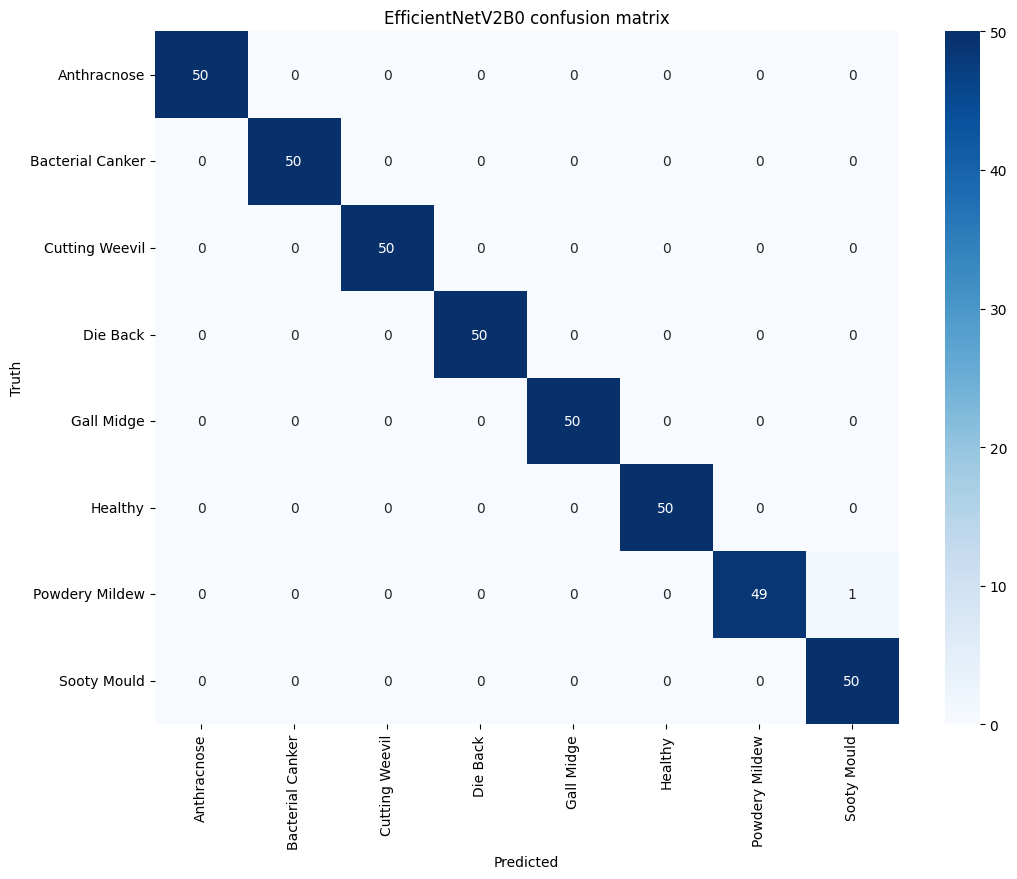

In [16]:
vals = pd.DataFrame(history.history)
vals = vals.rename(columns={"loss":"Train Loss","val_loss":"Validation Loss","accuracy":"Train Accuracy","val_accuracy":"Validation Accuracy"})

predictions = model.predict(test_data)
y_pred = np.argmax(predictions, axis = 1)
y_true = test_data.classes
class_labels = list(test_data.class_indices.keys())

print(classification_report(y_true,y_pred, target_names=class_labels))

plt.figure(figsize = (12,9))
cm = confusion_matrix(y_true, y_pred)
# sns.heatmap(cm, annot=True,fmt='d',cmap= plt.cm.Blues)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title("EfficientNetV2B0 confusion matrix")
plt.show()

In [17]:
model.save("models/efficientNetB0.keras")

In [2]:
# Size model

import os
model_size = os.path.getsize("models/efficientNetB0.keras")
print(f"Model size: {model_size / (1024 * 1024):.2f} MB")


Model size: 16.37 MB


In [3]:
import tensorflow as tf

model = tf.keras.models.load_model('models/efficientNetB0.keras')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('models/efficientNetB0.tflite', 'wb') as f:
    f.write(tflite_model)

import zipfile

tflite_model_path = 'models/efficientNetB0.tflite'
zip_path = 'models/efficientNetB0.zip'

with zipfile.ZipFile(zip_path, 'w') as zipf:
    zipf.write(tflite_model_path)

INFO:tensorflow:Assets written to: C:\Users\saulo\AppData\Local\Temp\tmph3nqskp3\assets


INFO:tensorflow:Assets written to: C:\Users\saulo\AppData\Local\Temp\tmph3nqskp3\assets


Saved artifact at 'C:\Users\saulo\AppData\Local\Temp\tmph3nqskp3'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_4')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  1967573953296: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  1967573956176: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  1967529488656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1967529488464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1967529491344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1967529490960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1967529491728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1967529489040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1967531213840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1967531212880: TensorSpec(shape=(), dtype=tf.resource,

In [4]:
import os

tflite_model_path = 'models/efficientNetB0.tflite'  # or your actual path
size_bytes = os.path.getsize(tflite_model_path)
size_kb = size_bytes / 1024
size_mb = size_kb / 1024

print(f"Model size: {size_bytes} bytes ({size_kb:.2f} KB, {size_mb:.2f} MB)")

Model size: 16075452 bytes (15698.68 KB, 15.33 MB)


In [15]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import f1_score

interpreter = tf.lite.Interpreter(model_path='models/efficientNetB0.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

y_true = []
y_pred = []

# test_data is a generator, so we need to iterate over all batches
for i in range(len(test_data)):
    imgs, labels = test_data[i]  # imgs: (batch, 224, 224, 3), labels: (batch, num_classes)
    for img, label in zip(imgs, labels):
        input_data = np.expand_dims(img, axis=0).astype(input_details[0]['dtype'])
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        output = interpreter.get_tensor(output_details[0]['index'])
        pred = np.argmax(output, axis=1)[0]
        y_pred.append(pred)
        y_true.append(np.argmax(label))  # convert one-hot to class index

# Agora calcule o F1-score
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"F1-score: {f1:.4f}")

c:\Users\saulo\PIBIC\TinyML\.venv\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:

    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    



F1-score: 0.9975


F1-score: 0.0980
